<a href="https://colab.research.google.com/github/UoR-Vision/VisualDota/blob/main/src/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Environment Setting

***
<a id="import"></a>
## Import libraries

To import the required libraries for whole project.

In [1]:
# import the build-in required libraries
from collections import Counter, defaultdict
import os
import time
import warnings

# import the third-part required libraries
import cv2
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torchvision
import ultralytics
from zipfile import ZipFile


# check the versions of third-part libraries
print(f'matplotlib: {matplotlib.__version__}, numpy: {np.__version__}, pandas: {pd.__version__}')
print(f'torch: {torch.__version__}, torchvision: {torchvision.__version__}, ultralytics: {ultralytics.__version__}')

# check environment
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f'device: {device}')

WARNING  Ultralytics setting 'datasets_dir: ' must be different than 'runs_dir: '. Please change one to avoid possible issues during training. 
View Ultralytics Settings with 'yolo settings' or at 'C:\Users\weiji\AppData\Roaming\Ultralytics\settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
matplotlib: 3.9.0, numpy: 2.1.1, pandas: 2.2.3
torch: 2.6.0+cpu, torchvision: 0.21.0+cpu, ultralytics: 8.3.105
device: cpu


***
<a id="colab"></a>
## Adapting to the Colab Operating Environment

In Colab environment, it is neccessary to download the whole project from Github.

In [2]:
def is_colab():
    try:
        import google.colab
        return True
    except ImportError:
        return False


if is_colab():
    print("Running in Google Colab!")
    !git clone https: // github.com/UoR-Vision/VisualDota.git -b main
    %cd VisualDota/src
    try:
        from google.colab import drive
        drive.mount('/content/drive')
    except ImportError as e:
        print(f'failed to import google package: {e.msg}')
    DATASET_ROOT_DIR = '/content/drive/MyDrive/VisualDota/DOTA'
    MODEL_ROOT_DIR = '/content/drive/MyDrive/VisualDota/models'
else:
    print("Not running in Colab.")
    DATASET_ROOT_DIR = './data'
    MODEL_ROOT_DIR = '../models'

Not running in Colab.


***
<a id="hotload"></a>
## Hot Loading .py File

Here is to import custom .py file. It can be hot-loaded, just re-run the following cell.

Documentation comments are provided for each public function. To check the comments please use the help() function.

In [3]:
try:
    import importlib
except:
    !pip install importlib
    import importlib

In [4]:
try:
    import data_loader  # import data loader for data training
    import data_process  # import data_process for data pre-processing
    import modeling_faster_rcnn  # import faster-rcnn model
    import modeling_yolo11  # import yolo-v11 model
    import visual_utils  # import visual utils for visualization

except ModuleNotFoundError as e:
    print(f'[ERROR] fail to import a custom module at path: {os.path.abspath(".")}, msg: {e}.')
except Exception as e:
    print(f'[ERROR] fail to read module at path: {os.path.abspath(".")}, msg: {e}')
else:
    # Hot loading python files
    importlib.reload(data_loader)
    importlib.reload(data_process)
    importlib.reload(modeling_faster_rcnn)
    importlib.reload(modeling_yolo11)
    importlib.reload(visual_utils)

# 2 Exploratory data analysis

## 2.1 Object Category Distribution

In [5]:
zip_path = os.path.abspath("./data/labelTxt.zip")

category_counts = Counter()

with ZipFile(zip_path, 'r') as zip_file:
    for file_name in zip_file.namelist():
        if file_name.endswith('.txt'):
            with zip_file.open(file_name) as file:
                for line in file:
                    try:
                        parts = line.decode('utf-8').strip().split()
                        if len(parts) >= 10:
                            category = parts[8].strip()
                            category_counts[category] += 1
                    except Exception as e:
                        print(f"[ERROR] {file_name}: {e}")

# Convert to DataFrame
df_counts = pd.DataFrame(category_counts.items(), columns=["Category", "Count"])
df_counts = df_counts.sort_values(by="Count", ascending=False)

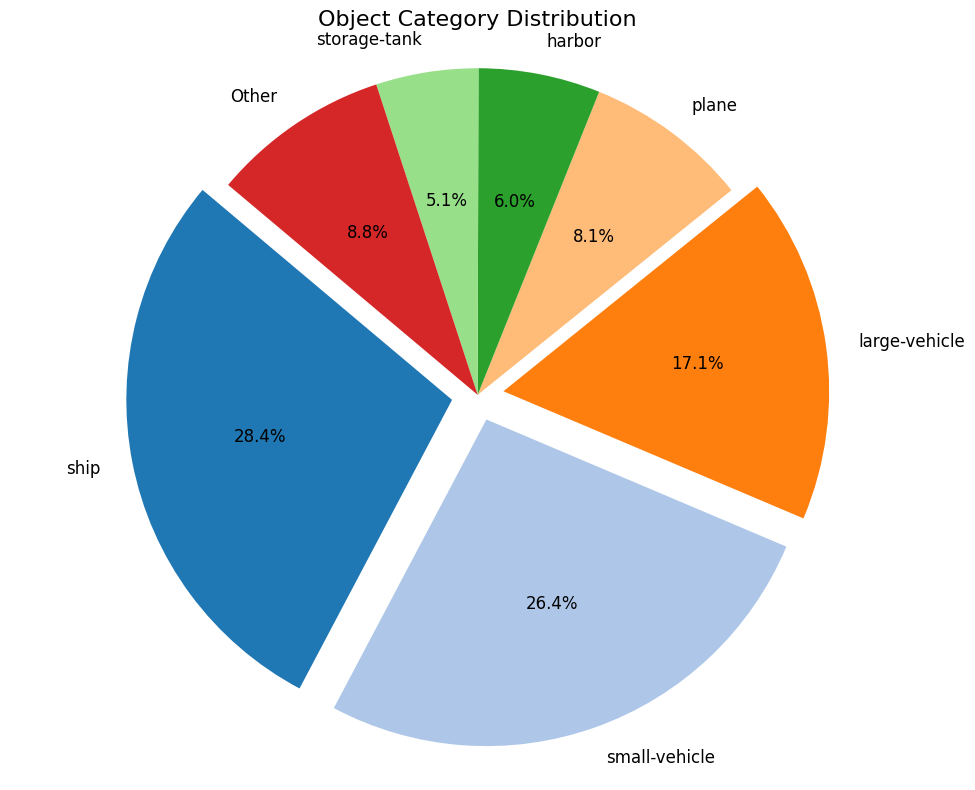

In [6]:
# Parameters
top_n = 6  # how many categories to show individually
colors = plt.cm.tab20.colors  # colorful palette

# Group small categories as 'Other'
df_counts_top = df_counts.head(top_n).copy()
other = df_counts.iloc[top_n:]["Count"].sum()
df_counts_top.loc[len(df_counts_top)] = ["Other", other]

# Create labels and data
labels = df_counts_top["Category"]
sizes = df_counts_top["Count"]

# Explode top 3 slightly
explode = [0.08 if i < 3 else 0 for i in range(len(sizes))]

# Plot
plt.figure(figsize=(10, 8))
plt.pie(
    sizes,
    labels=labels,
    autopct="%1.1f%%",
    startangle=140,
    explode=explode,
    colors=colors[:len(sizes)],
    textprops={'fontsize': 12}
)
plt.title("Object Category Distribution", fontsize=16)
plt.axis("equal")
plt.tight_layout()
plt.show()

## 2.2 Percentage of Difficult Annotations Per Category

In [7]:
# Initialize counters
category_total = defaultdict(int)
category_difficult = defaultdict(int)

# Parse the zip
with ZipFile(zip_path, 'r') as zip_file:
    for file_name in zip_file.namelist():
        if file_name.endswith('.txt'):
            with zip_file.open(file_name) as file:
                for line in file:
                    try:
                        parts = line.decode('utf-8').strip().split()
                        if len(parts) >= 10:
                            category = parts[8].strip()
                            difficult = parts[-1].strip()
                            category_total[category] += 1
                            if difficult == '1':
                                category_difficult[category] += 1
                    except Exception as e:
                        print(f"[ERROR] {file_name}: {e}")

In [8]:
# Combine into DataFrame
df_difficulty = pd.DataFrame({
    'Category': category_total.keys(),
    'Total': [category_total[c] for c in category_total],
    'Difficult': [category_difficult.get(c, 0) for c in category_total]
})

# Add % column
df_difficulty['Difficult %'] = (df_difficulty['Difficult'] / df_difficulty['Total']) * 100

# Sort by descending % of difficulty
df_difficulty = df_difficulty.sort_values(by='Difficult %', ascending=False)
df_difficulty.reset_index(drop=True, inplace=True)
df_difficulty.head()

,Category,Total,Difficult,Difficult %
0,soccer-ball-field,326,120,36.809816
1,storage-tank,5029,1005,19.984092
2,ground-track-field,325,36,11.076923
3,small-vehicle,26126,2646,10.127842
4,basketball-court,515,52,10.097087


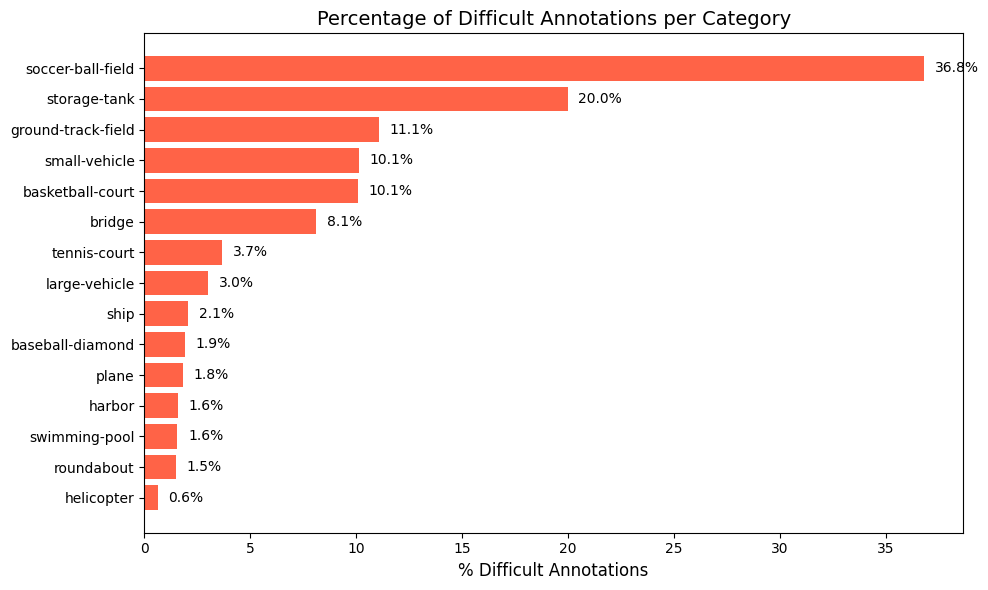

In [9]:
# Plotting
plt.figure(figsize=(10, 6))
bars = plt.barh(df_difficulty['Category'], df_difficulty['Difficult %'], color='tomato')
plt.xlabel('% Difficult Annotations', fontsize=12)
plt.title('Percentage of Difficult Annotations per Category', fontsize=14)

# Add text labels to bars
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.5, bar.get_y() + bar.get_height() / 2,
             f'{width:.1f}%', va='center', fontsize=10)

plt.gca().invert_yaxis()  # highest % on top
plt.tight_layout()
plt.show()

## 2.3 Object Bounding Box Sizes Per Category

In [10]:
# Shoelace formula for quadrilateral area
def polygon_area(x, y):
    return 0.5 * abs(sum(x[i] * y[(i + 1) % 4] - x[(i + 1) % 4] * y[i] for i in range(4)))


# Collect areas per category
category_areas = defaultdict(list)

with ZipFile(zip_path, 'r') as zip_file:
    for file_name in zip_file.namelist():
        if file_name.endswith('.txt'):
            with zip_file.open(file_name) as file:
                for line in file:
                    try:
                        parts = line.decode('utf-8').strip().split()
                        if len(parts) >= 10:
                            x_coords = list(map(float, parts[0:8:2]))  # x1, x2, x3, x4
                            y_coords = list(map(float, parts[1:8:2]))  # y1, y2, y3, y4
                            area = polygon_area(x_coords, y_coords)
                            category = parts[8].strip()
                            category_areas[category].append(area)
                    except Exception as e:
                        print(f"[ERROR] {file_name}: {e}")

In [11]:
# Flatten into long-form DataFrame
records = []
for category, areas in category_areas.items():
    for area in areas:
        records.append({'Category': category, 'Area': area})

df_area = pd.DataFrame(records)

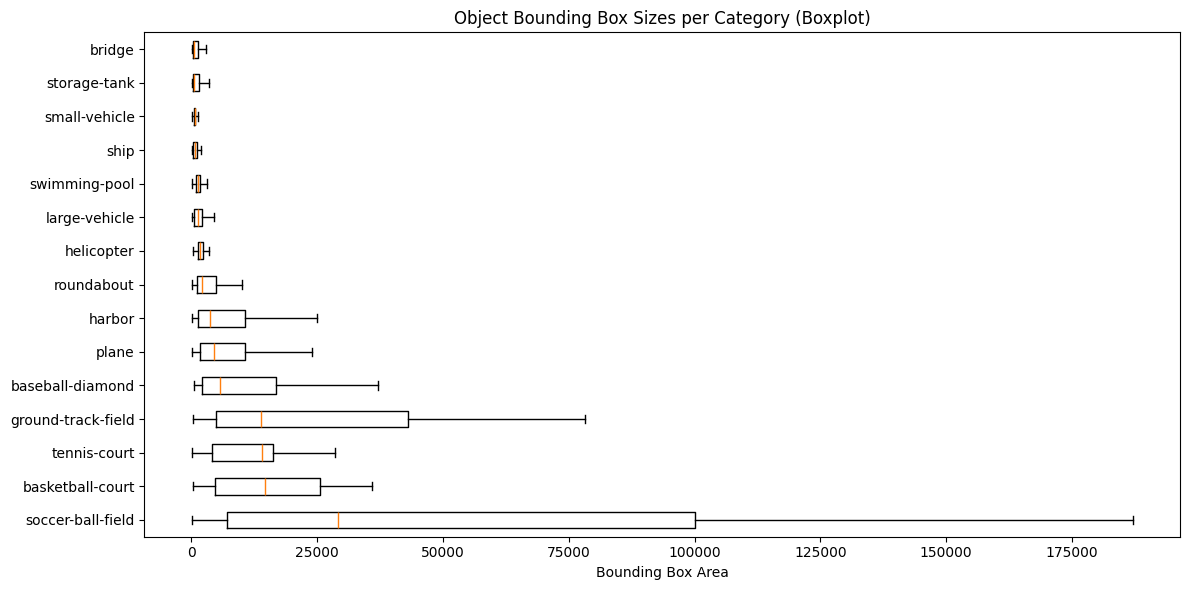

In [12]:
# Plotting
plt.figure(figsize=(12, 6))
sorted_categories = df_area.groupby("Category")["Area"].median().sort_values(ascending=False).index
df_area_sorted = df_area.copy()
df_area_sorted["Category"] = pd.Categorical(df_area_sorted["Category"], categories=sorted_categories)

plt.boxplot(
    [df_area_sorted[df_area_sorted["Category"] == cat]["Area"] for cat in sorted_categories],
    tick_labels=sorted_categories,
    showfliers=False,
    vert=False
)

# Add text labels to bars
plt.xlabel("Bounding Box Area")
plt.title("Object Bounding Box Sizes per Category (Boxplot)")
plt.tight_layout()
plt.show()

# 4 Modelling

## 4.1 You Only Look Once Model (YOLO V1)

### 4.1.1 Define Dataset Class and Load the Data

In [13]:
class YoloDataset(Dataset):
    def __init__(self, image_dir, label_dir, img_size=448):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.img_size = img_size
        self.image_files = sorted([f for f in os.listdir(image_dir) if f.endswith(".png")])

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        fname = self.image_files[idx]
        img_path = os.path.join(self.image_dir, fname)
        label_path = os.path.join(self.label_dir, fname.replace(".png", ".txt"))

        # Load image
        img = cv2.imread(img_path)
        img = cv2.resize(img, (self.img_size, self.img_size))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) / 255.0
        img = torch.tensor(img, dtype=torch.float32).permute(2, 0, 1)

        # Load label
        targets = []
        if os.path.exists(label_path):
            with open(label_path) as f:
                for line in f:
                    parts = line.strip().split()
                    if len(parts) == 5:
                        cls, x, y, w, h = map(float, parts)
                        targets.append([cls, x, y, w, h])

        targets = torch.tensor(targets, dtype=torch.float32)
        return img, targets

# Load the Data
image_dir = os.path.join(DATASET_ROOT_DIR, 'train/images')
label_dir = os.path.join(DATASET_ROOT_DIR, 'train/labelTxt')
## Use 1/3 data to train model
#image_dir = "/content/drive/MyDrive/images"
#label_dir = "/content/drive/MyDrive/labelTxt"

dataset = YoloDataset(image_dir, label_dir)
loader = DataLoader(dataset, batch_size=2, shuffle=True)

# Test loading
for imgs, labels in loader:
    print("Image batch shape:", imgs.shape)
    print("Labels shape:", labels.shape)
    break

Image batch shape: torch.Size([2, 3, 448, 448])
Labels shape: torch.Size([2, 0])


In [14]:
class YOLOv1(nn.Module):
    def __init__(self, S=7, B=2, C=15):
        super(YOLOv1, self).__init__()
        self.S = S
        self.B = B
        self.C = C

        def conv_block(in_c, out_c, pool=True):
            layers = [
                nn.Conv2d(in_c, out_c, 3, padding=1),
                nn.BatchNorm2d(out_c),
                nn.ReLU(inplace=True)
            ]
            if pool:
                layers.append(nn.MaxPool2d(2))
            return nn.Sequential(*layers)

        self.feature_extractor = nn.Sequential(
            conv_block(3, 32),
            conv_block(32, 64),
            conv_block(64, 128),
            conv_block(128, 256),
            conv_block(256, 512, pool=False),
            nn.AdaptiveAvgPool2d((7, 7))
        )

        self.head = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, S * S * (C + B * 5))
        )

    def forward(self, x):
        x = self.feature_extractor(x)
        x = self.head(x)
        return x.view(-1, self.S, self.S, self.C + self.B * 5)

In [15]:
class YOLOLoss(nn.Module):
    def __init__(self, S=7, B=2, C=15, lambda_coord=5, lambda_noobj=0.5):
        super(YOLOLoss, self).__init__()
        self.mse = nn.MSELoss(reduction='sum')
        self.S = S
        self.B = B
        self.C = C
        self.lambda_coord = lambda_coord
        self.lambda_noobj = lambda_noobj

    def forward(self, predictions, target):
        N = predictions.size(0)
        predictions = predictions.view(N, self.S, self.S, self.C + self.B * 5)
        target = target.view(N, self.S, self.S, self.C + self.B * 5)

        # Get mask for object cells
        obj_mask = target[..., self.C] > 0

        # No-object mask
        noobj_mask = target[..., self.C] == 0

        # ===================== #
        #   Coordinate Loss
        # ===================== #
        box_pred = predictions[..., self.C+1:self.C+5][obj_mask]
        box_target = target[..., self.C+1:self.C+5][obj_mask]

        coord_loss = self.mse(box_pred, box_target)

        # ===================== #
        #   Objectness Loss
        # ===================== #
        conf_pred = predictions[..., self.C][obj_mask]
        conf_target = target[..., self.C][obj_mask]
        obj_loss = self.mse(conf_pred, conf_target)

        # ===================== #
        #   No-object Loss
        # ===================== #
        noobj_pred = predictions[..., self.C][noobj_mask]
        noobj_target = target[..., self.C][noobj_mask]
        noobj_loss = self.mse(noobj_pred, noobj_target)

        # ===================== #
        #   Class Loss
        # ===================== #
        class_pred = predictions[..., :self.C][obj_mask]
        class_target = target[..., :self.C][obj_mask]
        class_loss = self.mse(class_pred, class_target)

        total_loss = (
            self.lambda_coord * coord_loss +
            obj_loss +
            self.lambda_noobj * noobj_loss +
            class_loss
        )

        return total_loss / N

### 4.1.2 YOLO Target Encoder

In [16]:
def encode_targets(targets, S=7, B=2, C=15):
    """
    Convert list of boxes [class, x, y, w, h] into a YOLOv1-style tensor.
    Output shape: [S, S, C + B*5]
    """
    target_tensor = torch.zeros((S, S, C + B * 5))

    for obj in targets:
        cls, x, y, w, h = obj
        i = int(x * S)
        j = int(y * S)

        if i >= S: i = S - 1
        if j >= S: j = S - 1

        x_cell = x * S - i
        y_cell = y * S - j

        if target_tensor[j, i, C] == 0:
            target_tensor[j, i, C] = 1  # object confidence
            target_tensor[j, i, C+1:C+5] = torch.tensor([x_cell, y_cell, w, h])
            target_tensor[j, i, int(cls)] = 1  # one-hot class

    return target_tensor

### 4.1.3 Model Training and Evaluation

In [17]:
def train_model(model, loader, optimizer, criterion, epochs=5, device='cuda'):
    model.to(device)
    history = []
    for epoch in range(epochs):
        start = time.time()
        model.train()
        total_loss = 0

        for imgs, targets in loader:
            imgs = imgs.to(device)
            labels = [encode_targets(t, C=15) for t in targets]
            labels = torch.stack(labels).to(device)

            preds = model(imgs)
            loss = criterion(preds, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        duration = time.time() - start
        loss_avg = total_loss / len(loader)
        history.append(loss_avg)

        print(f"Epoch {epoch+1}/{epochs} - {duration:.0f}s "
              f"{len(loader)} batches - loss: {loss_avg:.4f}")

    return history

In [18]:
model = YOLOv1()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = YOLOLoss(S=7, B=2, C=15)

train_loader = DataLoader(dataset, batch_size=2, shuffle=True)

history = train_model(model, train_loader, optimizer, criterion, epochs=10, device=device)

Epoch 1/10 - 13s 6 batches - loss: 9.6526
Epoch 2/10 - 12s 6 batches - loss: 10.2803
Epoch 3/10 - 12s 6 batches - loss: 9.2985
Epoch 4/10 - 12s 6 batches - loss: 8.2231
Epoch 5/10 - 13s 6 batches - loss: 5.4084
Epoch 6/10 - 12s 6 batches - loss: 3.7217
Epoch 7/10 - 12s 6 batches - loss: 2.6237
Epoch 8/10 - 12s 6 batches - loss: 1.2873
Epoch 9/10 - 12s 6 batches - loss: 0.5316
Epoch 10/10 - 12s 6 batches - loss: 0.2734


## 4.2 You Only Look Once Model (YOLO V11)

### 4.2.1 Summary of YOLO V11

In [19]:
# YOLOV11 model
yolo11 = modeling_yolo11.load_model(init=True)
yolo11

Transferred 490/541 items from pretrained weights
load model from ../models/yolo11/yolo11n-obb.pt, config: yolo11n-obb.yaml


YOLO(
  (model): OBBModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C3k2(
        (cv1): Conv(
          (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(48, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=

### 4.2.2 Model Training and Evaluation

In [20]:
yolo11_train_results = modeling_yolo11.train_model(yolo11, epochs=1)

New https://pypi.org/project/ultralytics/8.3.124 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.105  Python-3.11.4 torch-2.6.0+cpu CPU (13th Gen Intel Core(TM) i7-1360P)
engine\trainer: task=obb, mode=train, model=yolo11n-obb.yaml, data=../models/yolo11/yolo11n-obb-dota.yaml, epochs=1, time=None, patience=100, batch=2, imgsz=768, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train9, exist_ok=False, pretrained=../models/yolo11/yolo11n-obb.pt, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=

train: Scanning D:\project\ml\VisualDota\src\data\train\images - 副本.cache... 11 images, 181 backgrounds, 10 corrupt: 100%|██████████| 192/192 [00:00<?, ?it/s]

train: WARNING  D:\project\ml\VisualDota\src\data\train\images\P0000.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [2.7543945 2.3862305 3.3793945 3.3266602 3.1049805 4.083008  2.8232422
 4.166504  1.625     1.6655273 1.0053711 3.2817383 3.5585938 2.7109375
 2.1987305 1.0517578 3.4746094 1.1918945 4.163574  3.9047852 3.7456055
 1.5375977 3.9638672 1.3974609 4.4648438 2.2172852 3.2978516 2.9282227
 2.2109375 3.1669922 1.8398438 3.2207031 1.7080078 2.4750977 1.659668
 2.7919922 1.0942383 2.8969727 1.9750977 1.1918945 2.883789  4.072754
 3.102539  3.7094727 3.211914  3.4511719 3.319336  3.1933594 2.6640625
 3.7480469 3.5024414 1.2436523 3.5126953 1.2041016 3.4980469 1.1967773
 3.446289  1.1914062 3.4589844 1.1962891 1.0249023 1.0463867 3.459961
 2.7075195 1.4648438 1.8569336 1.4545898 2.1157227 1.4316406 1.918457
 1.4248047 1.7978516 1.4594727 2.0546875 1.4326172 2.0878906 1.0302734
 2.953125  3.378418  3.6889648 3.6796875 3.6713867 3.6069336 3.6010742
 3.5

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


D:\project\ml\VisualDota\venv\Lib\site-packages\albumentations\__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.6' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
val: Scanning D:\project\ml\VisualDota\src\data\val\labels... 34 images, 0 backgrounds, 22 corrupt: 100%|██████████| 34/34 [00:00<00:00, 43.09it/s]

val: WARNING  D:\project\ml\VisualDota\src\data\val\images\P0003.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [1.0664062 1.0761719 1.0810547 1.081543  1.0297852]
val: WARNING  D:\project\ml\VisualDota\src\data\val\images\P0004.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [1.1069336 1.2006836 1.2480469 1.2446289 1.2451172 1.2963867 1.3041992
 1.324707  1.2504883 1.0131836 1.0375977 1.0615234 1.0844727 1.1381836
 1.1625977 1.2358398 1.0419922 1.0678711 1.1401367 1.1625977 1.1889648
 1.2172852]
val: WARNING  D:\project\ml\VisualDota\src\data\val\images\P0007.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [1.0141602 1.7524414 1.4360352 1.4082031 1.3549805 1.328125  1.2988281
 1.515625  1.0151367 1.784668  1.0185547 1.7216797 1.5205078 1.0258789
 1.6386719 1.0268555 1.6088867 1.0307617 1.5800781 1.03125   1.5537109
 1.0322266 1.5253906 1.0351562 1.4970703 1.0292969 1.4692383 1.4633789
 1.5761

Plotting labels to obb\train9\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000526, momentum=0.9) with parameter groups 87 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 768 train, 768 val
Using 0 dataloader workers
Logging results to obb\train9
Starting training for 1 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/1         0G     0.1572      22.78     0.1194          0        768: 100%|██████████| 91/91 [03:20<00:00,  2.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.13it/s]


                   all         12        310          0          0          0          0

1 epochs completed in 0.059 hours.
Optimizer stripped from obb\train9\weights\last.pt, 5.7MB
Optimizer stripped from obb\train9\weights\best.pt, 5.7MB

Validating obb\train9\weights\best.pt...
Ultralytics 8.3.105  Python-3.11.4 torch-2.6.0+cpu CPU (13th Gen Intel Core(TM) i7-1360P)
YOLO11n-obb summary (fused): 109 layers, 2,656,648 parameters, 0 gradients, 6.6 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.46it/s]


                   all         12        310          0          0          0          0
                 plane          1          9          0          0          0          0
      baseball diamond          2          9          0          0          0          0
          tennis court          5         33          0          0          0          0
    ground track field          2          2          0          0          0          0
         large vehicle          4         59          0          0          0          0
         small vehicle          5        132          0          0          0          0
            roundabout          3          3          0          0          0          0
     soccer ball field          1          1          0          0          0          0
         swimming pool          4         62          0          0          0          0
Speed: 2.8ms preprocess, 241.0ms inference, 0.0ms loss, 37.9ms postprocess per image
Results saved to obb\trai

In [21]:
yolo11_val_results = modeling_yolo11.val_model(yolo11)

Ultralytics 8.3.105  Python-3.11.4 torch-2.6.0+cpu CPU (13th Gen Intel Core(TM) i7-1360P)
YOLO11n-obb summary (fused): 109 layers, 2,656,648 parameters, 0 gradients, 6.6 GFLOPs


val: Scanning D:\project\ml\VisualDota\src\data\val\labels.cache... 34 images, 0 backgrounds, 22 corrupt: 100%|██████████| 34/34 [00:00<?, ?it/s]

val: WARNING  D:\project\ml\VisualDota\src\data\val\images\P0003.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [1.0664062 1.0761719 1.0810547 1.081543  1.0297852]
val: WARNING  D:\project\ml\VisualDota\src\data\val\images\P0004.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [1.1069336 1.2006836 1.2480469 1.2446289 1.2451172 1.2963867 1.3041992
 1.324707  1.2504883 1.0131836 1.0375977 1.0615234 1.0844727 1.1381836
 1.1625977 1.2358398 1.0419922 1.0678711 1.1401367 1.1625977 1.1889648
 1.2172852]
val: WARNING  D:\project\ml\VisualDota\src\data\val\images\P0007.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [1.0141602 1.7524414 1.4360352 1.4082031 1.3549805 1.328125  1.2988281
 1.515625  1.0151367 1.784668  1.0185547 1.7216797 1.5205078 1.0258789
 1.6386719 1.0268555 1.6088867 1.0307617 1.5800781 1.03125   1.5537109
 1.0322266 1.5253906 1.0351562 1.4970703 1.0292969 1.4692383 1.4633789
 1.5761


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.53it/s]


                   all         12        310          0          0          0          0
                 plane          1          9          0          0          0          0
      baseball diamond          2          9          0          0          0          0
          tennis court          5         33          0          0          0          0
    ground track field          2          2          0          0          0          0
         large vehicle          4         59          0          0          0          0
         small vehicle          5        132          0          0          0          0
            roundabout          3          3          0          0          0          0
     soccer ball field          1          1          0          0          0          0
         swimming pool          4         62          0          0          0          0
Speed: 2.3ms preprocess, 225.9ms inference, 0.0ms loss, 39.5ms postprocess per image
Results saved to obb\trai

## 4.3 Faster Region-based Convolutional Neural Network (Faster RCNN)

### 4.3.1 Summary of Faster RCNN

In [22]:
# Faster-RCNN model
faster_rcnn = modeling_faster_rcnn.load_model(
    init=True,
    root=MODEL_ROOT_DIR,
)

### 4.3.2 Model Training and Evaluation

In [23]:
# Number of separating per edge
version = 1
separate = 5
# Data Loader for Faster-RCNN
faster_rcnn_data_loader = data_loader.faster_rcnn_data_loader(
    image_dir=os.path.join(DATASET_ROOT_DIR, 'train/images'),
    label_dir=os.path.join(DATASET_ROOT_DIR, 'train/labelTxt'),
    batch_size=2,
    num_workers=2,
)
# Train Faster-RCNN model
modeling_faster_rcnn.train_model(
    faster_rcnn,
    data_loader=faster_rcnn_data_loader,
    epochs=2,
)

training faster-rcnn model
processed 10 images.
Epoch 1 Loss: 13.32277258237203, loss_dict: {'loss_classifier': tensor(5.6212, grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(10.0726, grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.5592), 'loss_rpn_box_reg': tensor(0.4674)}
processed 10 images.
Epoch 2 Loss: 18.519744555155437, loss_dict: {'loss_classifier': tensor(2.7381, grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(1.7146, grad_fn=<DivBackward0>), 'loss_objectness': tensor(1.7486), 'loss_rpn_box_reg': tensor(1.3816)}


In [24]:
# Save Faster-RCNN model
modeling_faster_rcnn.save_model(
    faster_rcnn,
    model_name=f'fasterrcnn/fasterrcnn_s{separate}_v{version}.pth',
    model_path=MODEL_ROOT_DIR,
)

saved model to ../models\fasterrcnn/fasterrcnn_s5_v1.pth


### 4.3.3 Results and Discussion

In [25]:
test_img_path = os.path.join(DATASET_ROOT_DIR, 'test/images/P0006.png')
# Predict and Visualize the results
fasterrcnn_results = modeling_faster_rcnn.predict(
    faster_rcnn,
    image_path=test_img_path,
    confidence_threshold=0.3,
    separate=separate,
)

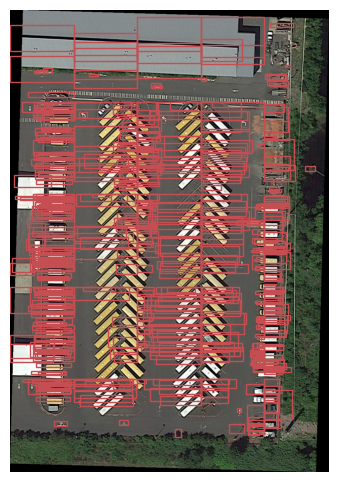

In [26]:
modeling_faster_rcnn.show_results(
    image_path=test_img_path,
    prediction=fasterrcnn_results,
    show_label=False,
)

# 5 Evaluation

# Summary